In [1]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import dataLoader as dl

#from Inner_Speech_Dataset.Plotting.ERPs import 
from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Calculate_power_windowed
from Inner_Speech_Dataset.Python_Processing.Utilitys import picks_from_channels


In [2]:
#Channel name array

def arrToDict(arr):
    dict = {}
    for row in arr:
        dict[row[0]] = row[1]
    
    return dict

def get_channelNames():
    ch_names = np.array(dl.get_channelnames())
    nr = np.arange(ch_names.shape[0])
    ch_names = np.array([ch_names, nr]).T
    ch_names = arrToDict(ch_names)
    return ch_names

def only_spec_channel_data(data , picks):
    
    channel_names_string = picks_from_channels(picks)
    ch_names = get_channelNames()
    channel_nr = []
    for name in  channel_names_string:
        channel_nr.append(int(ch_names[name]))
        print(ch_names[name])

    channel_nr = np.array(channel_nr)
    
    print(channel_nr)
    #data = np.swapaxes(data, 0, 1)
    #labels = np.swapaxes(labels, 0, 1)
    #for channelnrs in channels:
    data2 = np.delete(data, np.delete(np.arange(128), channel_nr) , axis=1)
    return data2


def get_power_array(split_data , samplingRate, trialSplit = 2,):

    #trialSplit = 16
    sR = samplingRate #samplingRate = 32
    data_power = np.zeros([split_data.shape[0], split_data.shape[1], trialSplit, 2])
    for t, trial in enumerate(split_data,0):
        for c, channel in enumerate(trial,0):
            for x in range(trialSplit):
                data_power[t, c, x, : ] = Calculate_power_windowed(channel, fc=sR, window_len=1*4/trialSplit, window_step=1*4/trialSplit, t_min=0, t_max=4/trialSplit * x + 4/trialSplit)
    

    #m_power , std_power
    print(data_power.shape)
    return data_power
    
data_p =  get_power_array(data, sampling_rate)
print(data_p.shape)

#Loading the data and labels from EEG and EXG

# data1, labels1 = dl.load_data(datatype="EEG", subject_nr=1, verbose=True,sampling_rate=sampling_rate) 
# data2, labels2 = dl.load_data(datatype="EEG", subject_nr=2 ,verbose=True,sampling_rate=sampling_rate )
# data4 , labels4 = dl.load_data(datatype="EEG", subject_nr=4, verbose=True,sampling_rate=sampling_rate) 

# dataX, labelsX = dl.load_data(datatype="EXG", verbose=False) 
# #datab, labelsb = dl.load_data(datatype="baseline", verbose=False, sampling_rate=32) 
# #dl.load_data(datatype2=2) #4.5 is max

####

#data = np.concatenate([data1, data2, data4], axis = 0)
#labels1d = np.concatenate([labels1, labels2, labels4], axis = 0)

####

#data = data1
#labels1d = labels1

sampling_rate = 64
data, labels = dl.load_multiple_datasets(nr_of_datasets=2, sampling_rate=64)
ch_names = get_channelNames()

data = only_spec_channel_data(data, "OPZ")
print(data.shape)


Data shape: [trials x channels x samples]
(500, 128, 320)
Labels shape
(500, 4)
Final data shape
(100, 128, 320)
Final labels shape
(100,)
Up is 0.0 and Down is 1.0
Up is 0.0 and Down is 1.0
16
29
19
20
21
[16 29 19 20 21]
(220, 5, 320)


(1008, 5, 2, 2)
(1008, 5, 2, 2)


In [13]:
#Splitting into training and test data
#print(labels)


order = np.arange(labels.shape[0])
np.random.shuffle(order)

temp_data = np.zeros(data.shape)
temp_labels = np.zeros(labels.shape)

for x in range(labels.shape[0]):
    i = order[x]
    
    temp_data[x] = data[i]
    temp_labels[x] = labels[i]

data = temp_data
labels = temp_labels

data_train, data_test = np.split(data, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
labels_train, labels_test = np.split(labels, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
print(labels_train.shape)
print(data_test.shape)




(756, 2)
(252, 5, 320)


In [14]:
#Convolution part

# Do the convs like I wrote in the Note
# First need to find out 8 best channels
#  Utilities can help average similar channels
# Read through article and how they did it better!
# convlayer = tf.keras.layers.Conv2D(4,
#  kernel_size=[2,1], input_shape= (data_train.shape[0], data_train.shape[1] , data_train.shape[2], 1,), 
#  padding="valid", strides=[round(data_train.shape[1]),1],
#  activation="relu")


# print(data_train.shape)
# print(data_test.shape)

# #data_train = np.swapaxes(data_train, 2, 1)
# #data_test = np.swapaxes(data_test, 2, 1)
# print(data_train.shape)
# print(data_test.shape)
# data_train = np.expand_dims(data_train, axis=0)
# data_test = np.expand_dims(data_test, axis=0)
# data_train = np.moveaxis(data_train, 0, -1)
# data_test = np.moveaxis(data_test, 0, -1)

# conv_data_train = convlayer(data_train)
# conv_data_test = convlayer(data_test)

# data_train = conv_data_train
# data_test = conv_data_test

# #data_train = np.swapaxes(data_train, 2, 1)
# #data_test = np.swapaxes(data_test, 2, 1)


# data_train = np.squeeze(np.moveaxis(data_train, -1, 0))
# data_test = np.squeeze(np.moveaxis(data_test, -1, 0))
# print(data_train.shape)
# print(data_test.shape)

In [15]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.clear_session()





eeg_model = tf.keras.Sequential([
    layers.Flatten(input_shape = (data_train.shape[1],data_train.shape[2])),
    layers.Dense(units=data_train.shape[1]*data_train.shape[2], activation="relu"),
    layers.Dense(units=1000, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(units=200, activation="relu"),
    layers.Dropout(0.2),
    #layers.Flatten(input_shape = (5,160)),
    layers.Dense(units=2, activation="softmax")


])
eeg_model.build()
eeg_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1600)              2561600   
                                                                 
 dense_1 (Dense)             (None, 1000)              1601000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 200)               200200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 4

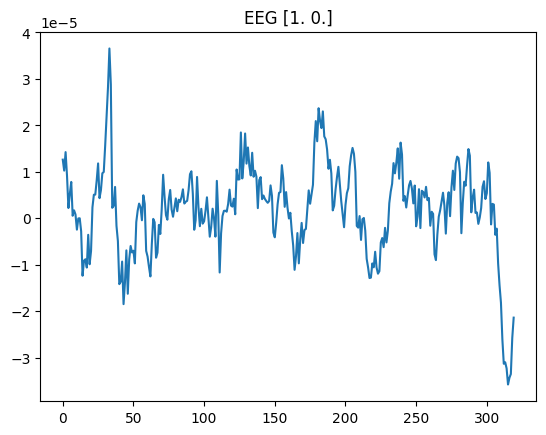

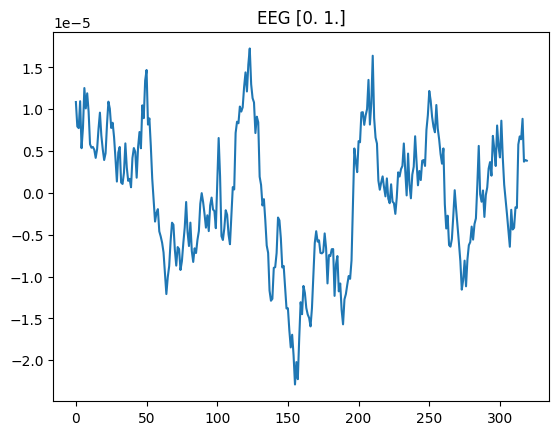

In [16]:
for trialNr, trial in enumerate(data_train[44:46],1):
    for channel in trial[1:2]:
        plt.figure()
        plt.plot(channel)
        plt.title("EEG {}".format(labels_train[trialNr]))

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=2)

eeg_model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

outputs = eeg_model.fit(data_train, labels_train, callbacks=[callback, tensorboard_callback],epochs=10)

print("Results")
eeg_model.evaluate(data_test, labels_test)
result = eeg_model.predict(data_test)


Epoch 1/10
24/24 [==============================] - 2s 52ms/step - loss: 0.6937 - accuracy: 0.5093
Epoch 2/10
24/24 [==============================] - 1s 25ms/step - loss: 0.6933 - accuracy: 0.5185
Epoch 3/10
24/24 [==============================] - 1s 50ms/step - loss: 0.6930 - accuracy: 0.5159
Epoch 4/10
24/24 [==============================] - 1s 24ms/step - loss: 0.6930 - accuracy: 0.5159
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.6933 - accuracy: 0.5159
Epoch 6/10
24/24 [==============================] - 1s 25ms/step - loss: 0.6929 - accuracy: 0.5159
Epoch 7/10
24/24 [==============================] - 1s 48ms/step - loss: 0.6929 - accuracy: 0.5159
Epoch 8/10
24/24 [==============================] - 1s 24ms/step - loss: 0.6930 - accuracy: 0.5159
Results
8/8 [==============================] - 0s 6ms/step


In [18]:
result2 = []
print(result)
for res in result:
    x = np.maximum(res[0], res[1])
    result2.append(int(np.where(res == x)[0]))

result2 = np.array(result2)
print(result2)

[[0.4693958  0.5306042 ]
 [0.46939772 0.5306022 ]
 [0.46939963 0.53060037]
 [0.4694023  0.53059775]
 [0.4693997  0.53060037]
 [0.46939665 0.5306033 ]
 [0.469398   0.53060204]
 [0.4693963  0.5306037 ]
 [0.46939713 0.5306028 ]
 [0.46939898 0.53060097]
 [0.46939468 0.5306053 ]
 [0.469399   0.53060097]
 [0.46939477 0.53060526]
 [0.46940175 0.5305983 ]
 [0.46939644 0.5306035 ]
 [0.4693968  0.5306032 ]
 [0.46940017 0.5305999 ]
 [0.4693952  0.5306048 ]
 [0.46939963 0.53060037]
 [0.4694058  0.53059417]
 [0.4693995  0.5306004 ]
 [0.4693991  0.53060097]
 [0.46939862 0.53060144]
 [0.46939734 0.53060263]
 [0.46939886 0.5306011 ]
 [0.4693992  0.53060085]
 [0.4693974  0.53060263]
 [0.46940023 0.5305998 ]
 [0.46939775 0.5306023 ]
 [0.469398   0.530602  ]
 [0.46939886 0.53060114]
 [0.46939662 0.53060335]
 [0.4693958  0.53060424]
 [0.46939704 0.530603  ]
 [0.46939552 0.5306044 ]
 [0.469398   0.530602  ]
 [0.46939513 0.53060484]
 [0.46939564 0.5306043 ]
 [0.46939874 0.5306012 ]
 [0.46939862 0.5306014 ]


In [19]:


for trialNr, trial in enumerate(data[44:46],44):
    for channel in trial[5:6]:
        plt.figure()
        plt.plot(channel)
        plt.title("EEG {}".format(labels[trialNr]))

      